In [1]:
#Imports
import sys
sys.path.append('python/')
import dataPython as dp
import numpy as np
import lmfit as lf
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.interpolate as inter
#import logging as log

In [2]:
data_bh_nord = dp.getXYdata('ngc 5533 total/data/NGC5533-blackhole_fmt.txt')  #getting noordermeer's traced data

#Black hole (Noordermeer's)
#convert to numpy arrays
r_bh_nord = np.asarray(data_bh_nord['xx'])
v_bh_nord = np.asarray(data_bh_nord['yy'])


#smoothing
#rdata = np.linspace(0.1,5,50) 
#ydata = np.zeros(data_bh_nord['yy']) 
#r_bh_nord = r_bh_nord[r_bh_nord.argsort()]
#v_bh_nord = v_bh_nord[r_bh_nord.argsort()]
#idx = np.arange(0,np.shape(r_bh_nord)[0])
#f_v_bh_nord = inter.InterpolatedUnivariateSpline(r_bh_nord[idx%1==0], v_bh_nord[idx%1==0], k=3)
#yydata = np.vectorize(f_v_bh_nord)


In [4]:
#Function
def v(r,G,M):          #Independent variable must be listed first for scipy to know how to fit it.
    return np.sqrt(G*M/r)  #In python, anything unset must be listed as a variable in the function, including the parameters we fit for.

#Points representing function - this is necessary to plot f(x) for our comparison.
ycurve = np.sqrt(4.3e-6*2.7e9/r_bh_nord)


In [6]:
#SCIPY FITTING
#Setup
#Initial Guesses for G and M. In this case, our initial guess is the true function.
p0 = [4.0e-6,2.0e9] #Parameters should be in the same order here as they were when we defined our function.
bounds = [0,np.inf]  #KITTYADD bc sqrt can't be negative

#Do fit
s_fit = opt.curve_fit(v,r_bh_nord,v_bh_nord,p0,bounds=bounds,absolute_sigma=True) #absolute_sigma is set so that uncertainties aren't treated as percentages.
#print(s_fit) #If we uncomment this line, we see that s_fit is an array containing two arrays.

#Define parameters from fit. Our parameters are stored in the first array in our fit output, in the order they were listed in f.
s_G = s_fit[0][0]
s_M = s_fit[0][1]
#s_c = s_fit[0][2]

#Define error from fit.
s_cov = s_fit[1]                    #The second array in the fit output is a covariance matrix.
s_error = np.sqrt(np.diag(s_cov)) #The diagonals of the covariance matrix are the variances of individual parameters.
s_Ge = s_error[0]                   #The errors will be in an order corresponding to the order of the parameters in their array
s_Me = s_error[1]
#s_ce = s_error[2]

#Create array to plot
s_curve = np.sqrt(s_G*s_M/r_bh_nord) #KITTYCHANGE just the equation again but with the array for G and M

#Print Values
print('G: '+str(s_G)+u' \u00B1 '+str(s_Ge))
print('M: '+str(s_M)+u' \u00B1 '+str(s_Me))
#print('c: '+str(s_c)+u' \u00B1 '+str(s_ce))

G: 4.796398375237048e-06 ± 1.0971546051483359e-08
M: 2480468750.0 ± 2.1231771510969187e-23


In [8]:
#LMFIT FITTING
#Setup
#weighdata = 1/sigdata                       #We will need weights for lmfit. This tells us how much to account for a single data point in the fit.
l_mod = lf.Model(v)                         #Tell lmfit that we want to model the function f
params = l_mod.make_params(G=4.3e-6, M=2.7e9)   #Give lmfit our initial guesses - again, the true function
params.add('G', value=4.3e-6, min=0) #KITTYADD so lmfit doesn't guess negative values (bc G is so lose to zero)
params.add('M', value=2.7e9, min=0)   #KITTYADD so lmfit doesn't guess negative values 

#Do fit
l_fit = l_mod.fit(v_bh_nord, params, r=r_bh_nord, nan_policy='omit') #Here is where the weights we set at the beginning come in.

#Define Stuff
l_dict = l_fit.best_values #l_fit has a lot of output. We want to use the final result.
l_G = l_dict['G']          #Dictionary items are called based on their name.
l_M = l_dict['M']          #So, we don't have to track the order of parameters.
#l_c = l_dict['c']

#Create array to plot
l_curve = np.sqrt(l_G*l_M/r_bh_nord)  #KITTYCHANGE again, just equation only now with these second array things

l_fit #Display information about the fit

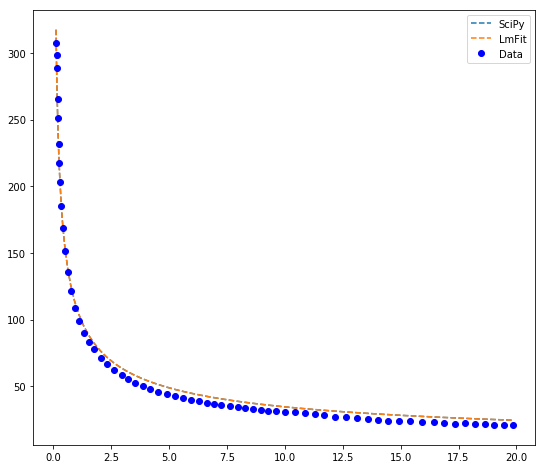

In [10]:
#Plotting

fig = plt.figure(figsize=(9.0,8.0))                #size of the plot

plt.errorbar(r_bh_nord,v_bh_nord,fmt='bo',label='Data') #Plot points (fmt='*o') with error bars
#plt.plot(r_bh_nord,ycurve,label='Function')                      #Accepting default style gives us a solid line
plt.plot(r_bh_nord,s_curve,linestyle='--',label='SciPy')         #Plot the scipy curve fit with a dashed line
plt.plot(r_bh_nord,l_curve,linestyle='--',label='LmFit')

plt.legend()           #Tells our plot to show a legend
plt.show()             #Depending how your environment is set up, this line may not be necessary, but it won't break anything.